In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import numpy.linalg as LA

In [2]:
from algorithms.meshforrectangle import MeshForRectangle

In [3]:
w = 1
h = 2
rectangle = [[0,0],[0,h],[w,h],[w,0]]
rectangle_area = h*w

u = lambda x, y: (x - 1)**2 * (y - 2)**2 *x*y
a11 = 1
a22 = 1
#a12 = 0
#a21 = 0

d = 0 #1
# f = lambda x, y: 3

#f = lambda x, y: 2 * x * (x - 1)**2 * (3*y - 4) + 2*(3*x - 2)*(y - 2)**2 * y
f = lambda x, y: 2*(-2+3*x)*(-2+y)**2*y+2*(-1+x)**2*x*(-4+3*y)

beta = 1e-10
sigma = 1e+10
psi = 0

In [4]:
nx = 2
ny = 4
mesher = MeshForRectangle(nx, ny)
triangulation = list(map(lambda t: t.get_points(), mesher.triangulate(rectangle)))

In [5]:
points = np.unique(np.concatenate(triangulation), axis=0).tolist()
triangles = list(map(lambda tri: [points.index(tri[0]),
                                  points.index(tri[1]),
                                  points.index(tri[2]),], triangulation))

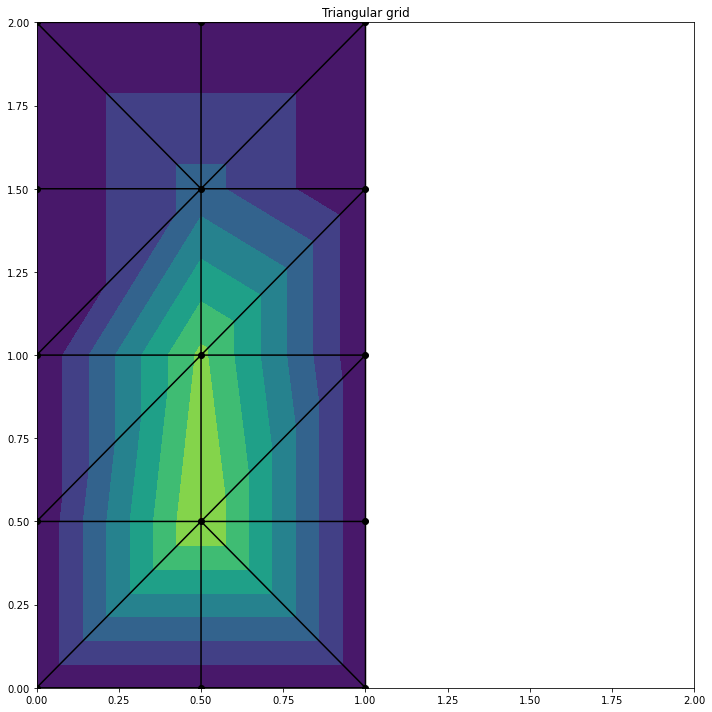

In [6]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
ax.tricontourf(triang, z)
ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')

fig.tight_layout()
plt.savefig('s.pdf')
plt.show()

In [7]:
n =  len(triangles)
triangle_area = rectangle_area / n
s = triangle_area

def K_i(b, c, s, a11, a22):
#     K = np.zeros([3, 3])
#     for i in range(3):
#         for j in range(3):
#             K[i][j] = (a11 * (b[i] * b[j]) + a22 * (c[i] * c[j]))

#     K = K / (2 * 2 * s)
#     print(b)
#     print(c)
#     print('-')
    K = np.array([[-1, 0.5, 0.5], [0.5, -0.5, 0], [0.5, 0, -0.5]])
#     print(K)
#     print("-")
    return K


def fill_A_with_K_i(A, K, tri):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += K[i][j]  
    
def fill_A_with_M_i(A, M, tri):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += M[i][j]   
            
def fill_F_with_phi_i(F, tri, points=points, Me=[]):
#     Qe = Me.dot(
#         np.array([ [ f(*points[tri[0]]) ], [ f(*points[tri[1]]) ], [ f(*points[tri[2]]) ]])
#     )
    
    Qe = np.array([ [ f(*points[tri[0]]) ], [ f(*points[tri[1]]) ], [ f(*points[tri[2]]) ]]) * 0.010419
    for i in range(3):
        F[tri[i]] += Qe[i][0]


In [8]:
G = h / ny

Re = (sigma*G)/(6*beta) * np.array([[2, 1], [1, 2]])
Pe = (psi*G)/(2*beta) * np.array([1, 1])
Me = d * (s)/(12) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

a = np.zeros([n, 3])
b = np.zeros([n, 3])
c = np.zeros([n, 3])
phi = np.zeros([n, 3])

A = np.zeros([len(points), len(points)])
F = np.zeros([len(points), 1])

for i, tri in enumerate(triangles):
    
    p1 = points[tri[0]]
    p2 = points[tri[1]] 
    p3 = points[tri[2]]
    
    groups = [
        (p2, p3, _), (p3, p1, _), (p1, p2, _)
    ]
    
    for j, group in enumerate(groups): #rewrite
        t1 = group[0]
        t2 = group[1]
#         print(t1)
#         print(t2)
        
        b[i][j] = t2[1] - t1[1]
        c[i][j] = t2[0] - t1[0]
        
    K = K_i(b[i], c[i], s, a11, a22)
    fill_A_with_K_i(A, K, tri)
    fill_A_with_M_i(A, Me, tri)
    fill_F_with_phi_i(F, tri, Me=Me)
    
    boundary_points = np.array([])
    if sum(np.array([p1[0], p2[0], p3[0]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == 0]
    elif sum(np.array([p1[0], p2[0], p3[0]]).round(5) == w) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == w]        
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == 0]
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == h) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == h]

    if boundary_points.size:

        boundary_points = boundary_points.tolist()
        if p2 not in boundary_points:
            boundary_points.reverse()

        A[points.index(boundary_points[0])][points.index(boundary_points[0])] = Re[0][0]
        A[points.index(boundary_points[0])][points.index(boundary_points[1])] = Re[0][1]
        A[points.index(boundary_points[1])][points.index(boundary_points[0])] = Re[1][0]
        A[points.index(boundary_points[1])][points.index(boundary_points[1])] = Re[1][1]
        
        F[points.index(boundary_points[0])] = Pe[0]
        F[points.index(boundary_points[1])] = Pe[1]
        #continue
    
    



In [9]:
b = LA.solve(A, F)

In [18]:
Re

array([[1.66666667e+19, 8.33333333e+18],
       [8.33333333e+18, 1.66666667e+19]])

In [10]:
print(F)

[[ 0.        ]
 [-0.0468855 ]
 [-0.041676  ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.12763275]
 [-0.0781425 ]
 [-0.01823325]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


In [11]:
with np.printoptions(formatter={'float': '{: 0.1f}'.format}):
    print(A)

[[ 16666666666666665984.0  8333333333333332992.0  0.0  0.0  0.0
   8333333333333332992.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0]
 [ 8333333333333332992.0  16666666666666665984.0  8333333333333332992.0
   0.0  0.0  0.0  0.5  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0]
 [ 0.0  8333333333333332992.0  16666666666666665984.0
   8333333333333332992.0  0.0  0.0  0.0  0.5  1.0  0.0  0.0  0.0  0.0
   0.0  0.0]
 [ 0.0  0.0  8333333333333332992.0  16666666666666665984.0
   8333333333333332992.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0
   0.0]
 [ 0.0  0.0  0.0  8333333333333332992.0  16666666666666665984.0  0.0  0.0
   0.0  0.5  8333333333333332992.0  0.0  0.0  0.0  0.0  0.0]
 [ 8333333333333332992.0  0.0  0.0  0.0  0.0  16666666666666665984.0  0.5
   0.0  0.0  0.0  8333333333333332992.0  0.0  0.0  0.0  0.0]
 [ 1.0  0.5  0.0  0.0  0.0  0.5 -4.5  0.5  0.0  0.0  0.5  0.5  1.0  0.0
   0.0]
 [ 0.0  1.0  0.5  0.0  0.0  0.0  0.5 -4.0  0.5  0.0  0.0  0.0  0.5  1.0
   0.0]
 [ 0.0  0.0  1.0  0.5  0.5

In [12]:
# with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
#     print(F)

In [13]:
ex = [u(*p) for p in points]

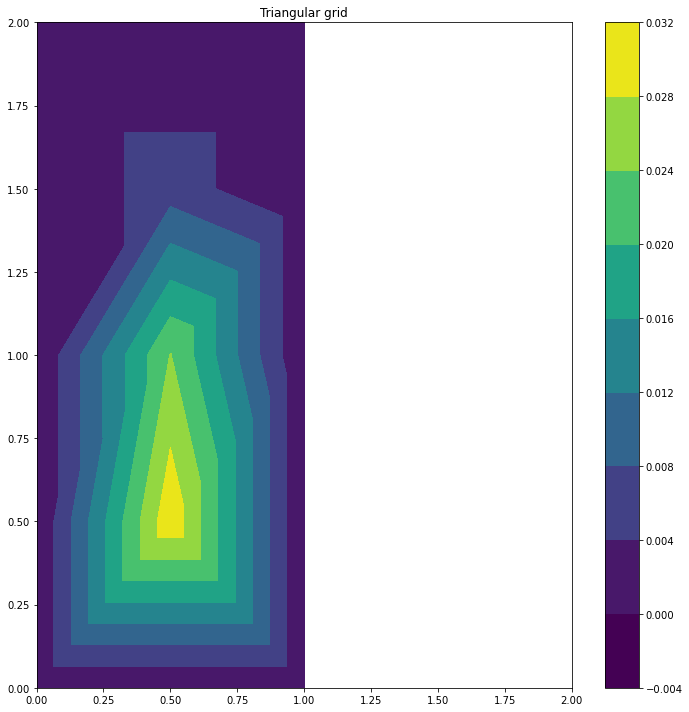

In [14]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = b.ravel()

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
cp.set_clim(np.min(b), np.max(b))
fig.colorbar(cp)

# ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

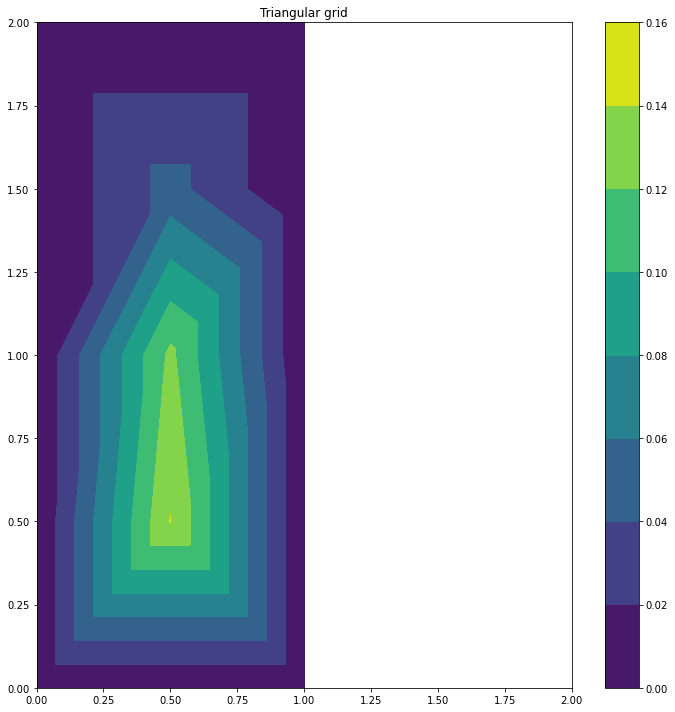

In [15]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

In [16]:
# def show_success(index):
#     point_index = int(len(points) * index)

#     print("Exact solution: \t", ex[point_index])
#     print("Approximate solution: \t", *b[point_index])
#     print("Error: \t\t\t", np.abs(ex[point_index] - b[point_index][0]))
#     print('{:.2e}'.format(np.abs(ex[point_index] - b[point_index][0])))
#     print()


In [17]:
# for coef in [0, 0.1, 0.57, 0.81]:    show_success(coef)